# Load the diffusion model, SAM, Mediapipe

In [1]:
import torch
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os.path as osp
import skimage.io as io
import cv2
import mediapipe as mp
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import vqvae 
import vit
from diffusion import create_diffusion
from utils import (
    scale_keypoint,  
    keypoint_heatmap, 
    check_keypoints_validity)
from segment_hoi import init_sam, show_mask


def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


def unnormalize(x):
    return (((x + 1) / 2) * 255).astype(np.uint8)


def visualize_hand(ax, all_joints, img):
# Define the connections between joints for drawing lines and their corresponding colors
    connections = [
        ((0, 1), 'red'), ((1, 2), 'green'), ((2, 3), 'blue'), ((3, 4), 'purple'),
        ((0, 5), 'orange'), ((5, 6), 'pink'), ((6, 7), 'brown'), ((7, 8), 'cyan'),
        ((0, 9), 'yellow'), ((9, 10), 'magenta'), ((10, 11), 'lime'), ((11, 12), 'indigo'),
        ((0, 13), 'olive'), ((13, 14), 'teal'), ((14, 15), 'navy'), ((15, 16), 'gray'),
        ((0, 17), 'lavender'), ((17, 18), 'silver'), ((18, 19), 'maroon'), ((19, 20), 'fuchsia')
    ]
    H, W, C = img.shape
    
    # Plot joints as points
    ax.imshow(img)
    for start_i in [0, 21]: 
        joints = all_joints[start_i: start_i+21]
        for connection, color in connections:
            joint1 = joints[connection[0]]
            joint2 = joints[connection[1]]
            ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], color=color)

    ax.set_xlim([0, W])
    ax.set_ylim([0, H])
    ax.grid(False)
    ax.set_axis_off()
    ax.invert_yaxis()
    

@dataclass
class HandDiffOpts:
    run_name: str = 'ViT_256_handmask_heatmap_nvs_b25_lr1e-5'
    sd_path: str = '/users/kchen157/scratch/weights/SD/sd-v1-4.ckpt'
    log_dir: str = '/users/kchen157/scratch/log'
    data_root: str = '/users/kchen157/data/users/kchen157/dataset/handdiff'
    image_size: tuple = (256, 256)
    latent_size: tuple = (32, 32)
    latent_dim: int = 4
    mask_bg: bool = False
    kpts_form: str = 'heatmap'
    n_keypoints: int = 42
    n_mask: int = 1
    noise_steps: int = 1000
    test_sampling_steps: int = 250
    ddim_steps: int = 100
    ddim_discretize: str = "uniform"
    ddim_eta: float = 0.
    beta_start: float = 8.5e-4
    beta_end: float = 0.012
    latent_scaling_factor: float = 0.18215
    cfg_pose: float = 5.
    cfg_appearance: float = 3.5
    batch_size: int = 25
    lr: float = 1e-5
    max_epochs: int = 500
    log_every_n_steps: int = 100
    limit_val_batches: int = 1
    n_gpu: int = 8
    num_nodes: int = 1
    precision: str = '16-mixed'
    profiler: str = 'simple'
    swa_epoch_start: int = 10
    swa_lrs: float = 1e-3
    num_workers: int = 10
    n_val_samples: int = 4
        

opts = HandDiffOpts()
model_path = './DINO_EMA_11M_b50_lr1e-5_epoch6_step320k.ckpt'
vae_path = './vae-ft-mse-840000-ema-pruned.ckpt'
sd_path = './sd-v1-4.ckpt'

print('Load diffusion model...')
diffusion = create_diffusion(str(opts.test_sampling_steps))
model = vit.DiT_XL_2(
    input_size=opts.latent_size[0],
    latent_dim=opts.latent_dim,
    in_channels=opts.latent_dim+opts.n_keypoints+opts.n_mask,
    learn_sigma=True,
).cuda()

# ckpt_state_dict = torch.load(model_path)['model_state_dict']
ckpt_state_dict = torch.load(model_path)['ema_state_dict']
missing_keys, extra_keys = model.load_state_dict(ckpt_state_dict, strict=False)
model.eval()
print(missing_keys, extra_keys)
assert len(missing_keys) == 0


vae_state_dict = torch.load(vae_path)['state_dict']
autoencoder = vqvae.create_model(3, 3, opts.latent_dim).eval().requires_grad_(False).cuda()
missing_keys, extra_keys = autoencoder.load_state_dict(vae_state_dict, strict=False)
autoencoder.eval()
assert len(missing_keys) == 0


print('Mediapipe hand detector and SAM ready...')
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,  # Use False if image is part of a video stream
    max_num_hands=2,         # Maximum number of hands to detect
    min_detection_confidence=0.1)
sam_predictor = init_sam(ckpt_path='./sam_vit_h_4b8939.pth')

Load diffusion model...
Mediapipe hand detector and SAM ready...


I0000 00:00:1722117494.286604 1425447 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1722117494.348364 1425537 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.129.03), renderer: NVIDIA A40/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# Load the image to fix and get annotations.

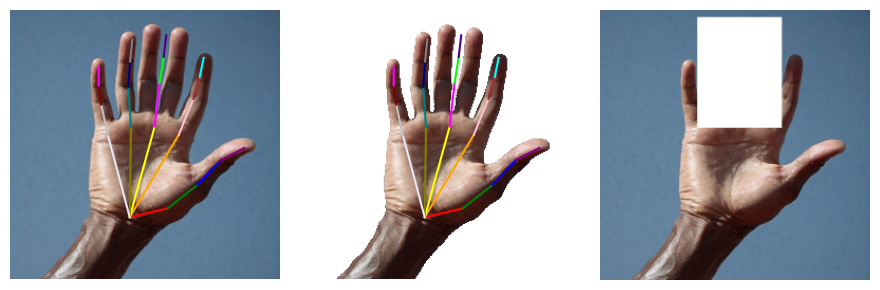

In [2]:
# read image
flip_image = False
sample_image_path = './test_data/bad_hands/5.jpg'
inpaint_image_file = './test_data/bad_hands/5_mask.jpg'
img = io.imread(sample_image_path)
img = cv2.resize(img, opts.image_size, interpolation=cv2.INTER_AREA)
inpaint_image = io.imread(inpaint_image_file)
inpaint_image = cv2.resize(inpaint_image, opts.image_size, interpolation=cv2.INTER_AREA)
inpaint_mask = np.all(inpaint_image == 255, axis=-1).astype(np.uint8)
inpaint_latent_mask = torch.tensor(
    cv2.resize(inpaint_mask, dsize=opts.latent_size, interpolation=cv2.INTER_NEAREST), 
    dtype=torch.float, device='cuda').unsqueeze(0)[None, ...]
# detect keypoints
mp_pose = hands.process(img)
keypts = np.zeros((42, 2))
detected = np.array([0, 0])
start_idx = 0
if mp_pose.multi_hand_landmarks:
    # handedness is flipped assuming the input image is mirrored in MediaPipe
    for hand_landmarks, handedness in zip(mp_pose.multi_hand_landmarks, mp_pose.multi_handedness):
        # actually right hand
        if handedness.classification[0].label == 'Left':
            start_idx = 0
            detected[0] = 1
        # actually left hand
        elif handedness.classification[0].label == 'Right':
            start_idx = 21
            detected[1] = 1
        for i, landmark in enumerate(hand_landmarks.landmark):
            keypts[start_idx + i] = [landmark.x * opts.image_size[1], landmark.y * opts.image_size[0]]
            
        
    sam_predictor.set_image(img)
    l = keypts[:21].shape[0]
    if keypts[0].sum() != 0 and keypts[21].sum() != 0:
        input_point = np.array([keypts[0], keypts[21]])
        input_label = np.array([1, 1])
    elif keypts[0].sum() != 0:
        input_point = np.array(keypts[:1])
        input_label = np.array([1])
    elif keypts[21].sum() != 0:
        input_point = np.array(keypts[21:22])
        input_label = np.array([1])
    masks, _, _ = sam_predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    hand_mask = masks[0]
    masked_img = img * hand_mask[..., None] + 255*(1 - hand_mask[..., None])
    fig, axs = plt.subplots(1, 3, figsize=(3*3, 3))
    visualize_hand(axs[0], keypts, img)
    visualize_hand(axs[1], keypts, masked_img)
    axs[2].imshow(inpaint_image)
    axs[2].axis('off')
    axs[2].grid(False)
    plt.tight_layout()
    plt.show()

    ref_image = img
    ref_keypts = keypts
else:
    print('No hand detected')
    

def make_ref_cond(img, keypts, hand_mask, device='cuda', target_size=(256, 256), latent_size=(32, 32)):
    image_transform=Compose([
        ToTensor(),
        Resize(target_size),
        Normalize(
            mean=[0.5, 0.5, 0.5], 
            std=[0.5, 0.5, 0.5], inplace=True),
    ])
    image = image_transform(img).to(device)
    kpts_valid = check_keypoints_validity(keypts, target_size)
    heatmaps = torch.tensor(keypoint_heatmap(
        scale_keypoint(keypts, target_size, latent_size), 
        latent_size, var=1.) * kpts_valid[:, None, None], dtype=torch.float, device=device)[None, ...]
    mask = torch.tensor(
        cv2.resize(hand_mask.astype(int), dsize=latent_size, interpolation=cv2.INTER_NEAREST), 
        dtype=torch.float, device=device).unsqueeze(0)[None, ...]
    return image[None, ...], heatmaps, mask


image, heatmaps, mask = make_ref_cond(
    img, keypts, hand_mask * (1 - inpaint_mask), device='cuda', target_size=opts.image_size, latent_size=opts.latent_size)
latent = opts.latent_scaling_factor * autoencoder.encode(image).sample()
target_cond = torch.cat([
        heatmaps, 
        torch.zeros_like(mask)], 1)
ref_cond = torch.cat([latent, heatmaps, mask], 1) 
ref_cond = torch.zeros_like(ref_cond)

# Sample from diffusion model

In [ ]:
# N: number of samples 
N = 1
jump_length=10
jump_n_sample=10
cfg_scale = 3.0
z = torch.randn((N, opts.latent_dim, opts.latent_size[0], opts.latent_size[1]), device='cuda')
target_cond_N = target_cond.repeat(N, 1, 1, 1)
ref_cond_N = ref_cond.repeat(N, 1, 1, 1)
# novel view synthesis mode = off
nvs = torch.zeros(N, dtype=torch.int, device='cuda')
z = torch.cat([z, z], 0)
model_kwargs = dict(
    target_cond=torch.cat([target_cond_N, torch.zeros_like(target_cond_N)]), 
    ref_cond=torch.cat([ref_cond_N, torch.zeros_like(ref_cond_N)]), 
    nvs=torch.cat([nvs, 2 * torch.ones_like(nvs)]), 
    cfg_scale=cfg_scale)

samples, _ = diffusion.inpaint_p_sample_loop(
    model.forward_with_cfg, z.shape, latent, inpaint_latent_mask, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device='cuda',
    jump_length=jump_length, jump_n_sample=jump_n_sample,
).chunk(2)
sampled_images = autoencoder.decode(samples / opts.latent_scaling_factor) 
sampled_images = torch.clamp(sampled_images, min=-1., max=1.)
sampled_images = unnormalize(sampled_images.permute(0, 2, 3, 1).cpu().numpy())

#visualize
for k in range(N):
    fig, axs = plt.subplots(1, 4, figsize=(6*4, 6))
    for i, vis_img in enumerate([ref_image, inpaint_image, sampled_images[k]]):
        axs[i].imshow(vis_img)
        axs[i].axis('off')
        axs[i].grid(False)
    visualize_hand(axs[3], keypts, sampled_images[k])
    plt.tight_layout()
    plt.show()

  0%|          | 0/4570 [00:00<?, ?it/s]